In [1]:
import sys

sys.path.append('..') # Allows imports from parent folder

In [2]:
from datasets import load_dataset
from model import NERClassifier
from preprocess_dataset import NERDataset 
from trainner import Trainner
from transformers import BertTokenizer, BertTokenizerFast
from preprocess_dataset import remove_empty_entries

import torch

In [3]:
CHECKPOINT = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizerFast.from_pretrained(CHECKPOINT)

In [4]:
data = "lener_br"
dataset = load_dataset(data)
dataset = remove_empty_entries(dataset)

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-5e59bc59f25f3d7f.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-8d0457760cd67ee6.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-74e841c1c151996a.arrow


## Hyperparameters

In [5]:
MAX_LENS = [64, 128, 256]
LEARNING_RATE=3e-4
n_labels = 13
BATCH_SIZE=8
shuffle=True
NUM_EPOCHS=1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training models with different sizes

In [6]:
import pandas as pd
from evaluator import Evaluator
from torch.utils.data import DataLoader
from transformers import AdamW

In [7]:
data = {"f1_t":[], "f1_e":[], "loss_t": [], "loss_e": []}

for MAX_LEN in MAX_LENS:
        print(f"treinando para max_len={MAX_LEN}")
        pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)
        pytorch_dataset_test = NERDataset(data=dataset['test'], max_len=MAX_LEN, tokenizer=tokenizer)
        
        loader_t = DataLoader(pytorch_dataset_train, batch_size=BATCH_SIZE, shuffle=shuffle)
        loader_e = DataLoader(pytorch_dataset_test, batch_size=BATCH_SIZE, shuffle=shuffle)

        model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
        
        evaluator = Evaluator(loader_e, model, device)
        tr = Trainner(device,\
                      loader_t,\
                      model,\
                      optimizer,\
                      max_len=MAX_LEN,\
                      num_examples=len(pytorch_dataset_train),\
                      num_epochs=NUM_EPOCHS,\
                      evaluator=evaluator)
        print("Trainner carregado!")
        loss_t, loss_e, f1_e, f1_t = tr.train()
        print(f"Treino finalizado para max_len= {MAX_LEN}\n" + \
              f"loss_t:{loss_t}, loss_e:{loss_e}, f1_e:{f1_e}, f1_t:{f1_t}")
        data["f1_t"].append(f1_t[0]) # We return the f1 score for all epochs. Since we're using 
        data["f1_e"].append(f1_e[0]) # num_epochs=1, we'll just take the first item.
        data["loss_t"].append(loss_t[0])
        data["loss_e"].append(loss_e[0])
        del model

treinando para max_len=64


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Trainner carregado!
Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.5514931678771973 f1 nas ultimas 100 iterações: 0.002414778659889781 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.713729977607727 f1 nas ultimas 100 iterações: 0.7918494284851024 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.7832715511322021 f1 nas ultimas 100 iterações: 0.8164738345297345 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 1.158220648765564 f1 nas ultimas 100 iterações: 0.8198020743861129 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.7940226197242737 f1 nas ultimas 100 iterações: 0.8101011789848783 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.8869495391845703 f1 nas ultimas 100 iterações: 0.7983571905128422 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.6622911691665649 f1 nas ultimas 100 iterações: 0.8101786743366375 -

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Trainner carregado!
Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.4814345836639404 f1 nas ultimas 100 iterações: 0.002230526059820053 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 1.0500037670135498 f1 nas ultimas 100 iterações: 0.7718798577430174 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.6297072768211365 f1 nas ultimas 100 iterações: 0.8084005388905432 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 0.9996668696403503 f1 nas ultimas 100 iterações: 0.8243959054481684 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.4010274112224579 f1 nas ultimas 100 iterações: 0.8114025593674034 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.9502114653587341 f1 nas ultimas 100 iterações: 0.8386650715811883 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.3770126700401306 f1 nas ultimas 100 iterações: 0.8182630834355055

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Trainner carregado!
Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.6235768795013428 f1 nas ultimas 100 iterações: 0.0011229181892373214 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.513481855392456 f1 nas ultimas 100 iterações: 0.8080781226096486 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.6486738324165344 f1 nas ultimas 100 iterações: 0.7982537533049616 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 0.6562737226486206 f1 nas ultimas 100 iterações: 0.8167368296077856 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.65400230884552 f1 nas ultimas 100 iterações: 0.8350042888634828 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.6748431921005249 f1 nas ultimas 100 iterações: 0.8150438876200877 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.8918415307998657 f1 nas ultimas 100 iterações: 0.823409866339694 --

In [9]:
data

{'f1_t': [0.810203152027207, 0.8103210592313692, 0.8161405977820326],
 'f1_e': [0.8401468571893116, 0.83845205561234, 0.8400908868506554],
 'loss_t': [0.6883792681838324, 0.6906435551603188, 0.6663526960052131],
 'loss_e': [0.5694239393904291, 0.5845902770672037, 0.5714858781503535]}

In [10]:
from matplotlib import pyplot as plt

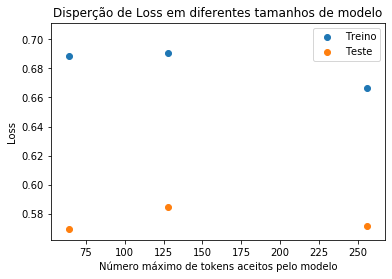

In [11]:
plt.scatter(x=MAX_LENS, y=data['loss_t'], label="Treino")
plt.scatter(x=MAX_LENS, y=data['loss_e'], label="Teste")
plt.xlabel("Número máximo de tokens aceitos pelo modelo")
plt.ylabel("Loss")
plt.title("Disperção de Loss em diferentes tamanhos de modelo")
plt.legend()
plt.show()

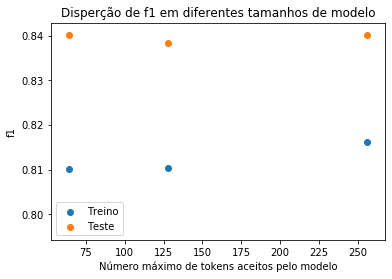

In [13]:
plt.scatter(x=MAX_LENS, y=data['f1_t'], label="Treino")
plt.scatter(x=MAX_LENS, y=data['f1_e'], label="Teste")
plt.xlabel("Número máximo de tokens aceitos pelo modelo")
plt.ylabel("f1")
plt.title("Disperção de f1 em diferentes tamanhos de modelo")
plt.legend()
plt.show()